# **Exploratory analysis of LUSC Visium V2 data**

started: 20/02/2025 author: Agathe Sobkowicz


## Import


### Import packages


In [3]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celltypist as ct

import data_analysis_functions as da

### Import data


In [4]:
current_dir = os.getcwd()
parrent_dir = os.path.dirname(current_dir)

In [5]:
path_to_data = os.path.join(parrent_dir, "LUSC_v2")
slide_folders = os.listdir(path_to_data)
slide_folders

['18P06762',
 '18P08140',
 '17P04394',
 '17P02529',
 '18P06593',
 '18P03122',
 '18P02831']

In [6]:
# Select slide to analyse
# #for slide in slide_folders:
slide = slide_folders[3]
path_to_slide = os.path.join(path_to_data, slide)

In [7]:
result_dir = os.path.join(parrent_dir, "lusc_v2_analysis_results")
os.makedirs(result_dir, exist_ok=True)

In [8]:
slide_result_dir = os.path.join(result_dir, f"{slide}_results")
os.makedirs(slide_result_dir, exist_ok=True)

In [9]:
# Inspect elements in slide folder
# da.print_tree(path_to_slide)

In [10]:
adata = sc.read_visium(path_to_slide)
adata.var_names_make_unique()

In [11]:
adata

AnnData object with n_obs × n_vars = 4925 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## QC


In [12]:
# Calculate QC metrics
adata.var["mt"] = [gene.startswith("MT-") for gene in adata.var_names]
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20])
adata.obs["mt_frac"] = (
    adata[:, adata.var["mt"]].X.sum(1).A.squeeze() / adata.obs["total_counts"]
)

In [13]:
round(adata.obs.describe())

in_tissue  array_row  array_col  n_genes_by_counts  \
count     4925.0     4925.0     4925.0             4925.0   
mean         1.0       39.0       64.0             5624.0   
std          0.0       23.0       37.0             2495.0   
min          1.0        0.0        0.0               55.0   
25%          1.0       19.0       32.0             3737.0   
50%          1.0       39.0       64.0             5475.0   
75%          1.0       58.0       95.0             7419.0   
max          1.0       77.0      127.0            11151.0   

       log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
count                   4925.0        4925.0              4925.0   
mean                       9.0       19095.0                 9.0   
std                        1.0       17398.0                 1.0   
min                        4.0          60.0                 4.0   
25%                        8.0        7160.0                 9.0   
50%                        9.0       13402.0                10.0   
75%                        9.0       24302.0                10.0   
max                        9.0      107900.0                12.0   

       pct_counts_in_top_20_genes  total_counts_mt  log1p_total_counts_mt  \
count                      4925.0           4925.0                 4925.0   
mean                         20.0            504.0                    6.0   
std                          13.0            687.0                    1.0   
min                           5.0              1.0                    1.0   
25%                           9.0            155.0                    5.0   
50%                          16.0            261.0                    6.0   
75%                          28.0            515.0                    6.0   
max                          63.0           5032.0                    9.0   

       pct_counts_mt  mt_frac  
count         4925.0   4925.0  
mean             2.0      0.0  
std              1.0      0.0  
min              1.0      0.0  
25%              2.0      0.0  
50%              2.0      0.0  
75%              3.0      0.0  
max              8.0      0.0

... storing 'feature_types' as categorical
... storing 'genome' as categorical


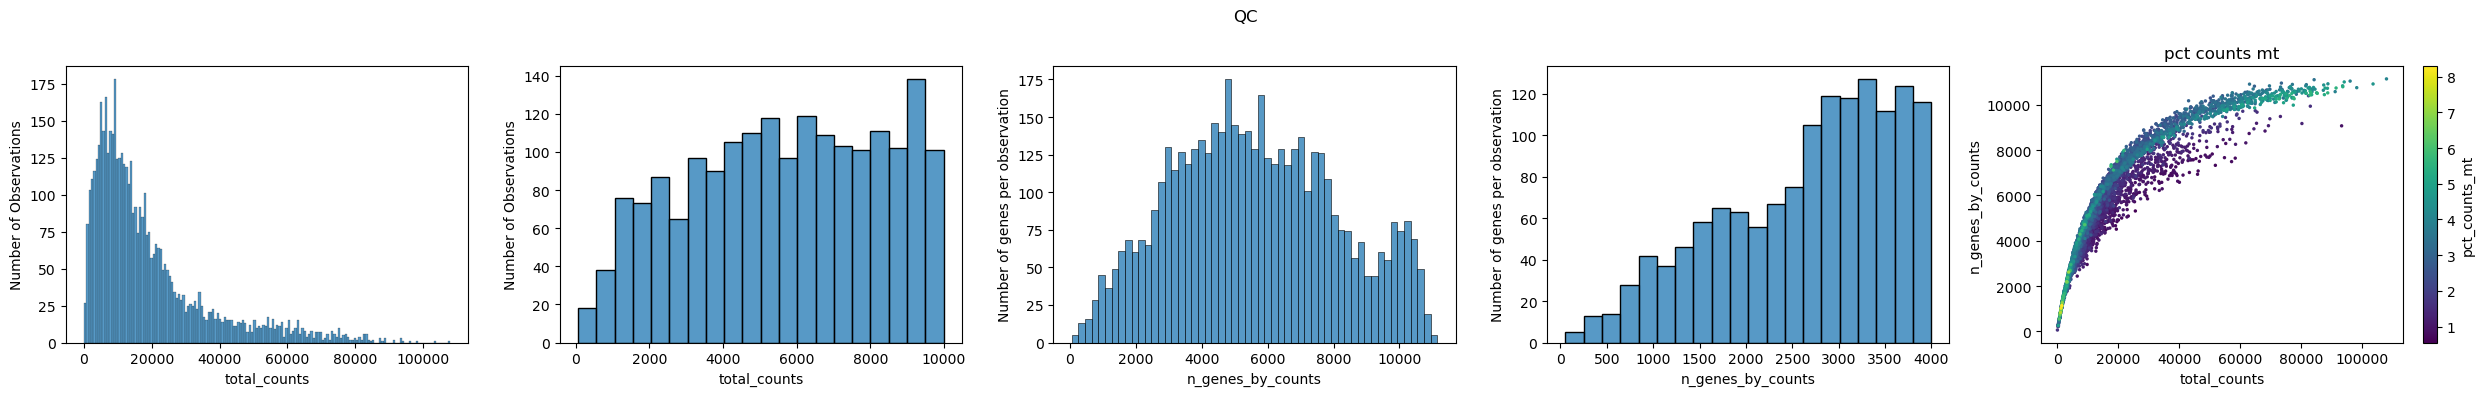

In [14]:
da.plot_count_gene_dist(adata)
plt.gcf().savefig(os.path.join(slide_result_dir, f"qc_{slide}.png"))

## Filtering


### Automatic filtering based on MAD


In [15]:
# adata.obs["outlier"] = (
#     da.is_outlier(adata, "log1p_total_counts", 5)
#     | da.is_outlier(adata, "log1p_n_genes_by_counts", 5)
#     | da.is_outlier(adata, "pct_counts_in_top_20_genes", 5)
# )
# adata.obs.outlier.value_counts()

In [16]:
# adata.obs["mt_outlier"] = da.is_outlier(adata, "pct_counts_mt", 3) | (
#     adata.obs["pct_counts_mt"] > 8
# )
# adata.obs.mt_outlier.value_counts()

In [17]:
# print(f"Number of cells before filtering: {adata.n_obs}")
# adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

# print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

### Manuel filtering of outliers


In [18]:
print(f"Before filtering there are : {adata.n_obs} cells and {adata.n_vars} genes.")
adata = da.tot_filter_genes(adata)
adata = adata[:, (~adata.var["Gene outlier"])].copy()
adata = da.tot_filter_cells(adata)

Before filtering there are : 4925 cells and 18085 genes.
Gene outlier
False    13776
True      4309
Name: count, dtype: int64
Cell outlier
False    4924
True        1
Name: count, dtype: int64


### Visualise filtering


In [19]:
if adata.obsm["spatial"].dtype == "object":
    adata.obsm["spatial"] = np.array(adata.obsm["spatial"], dtype=float)

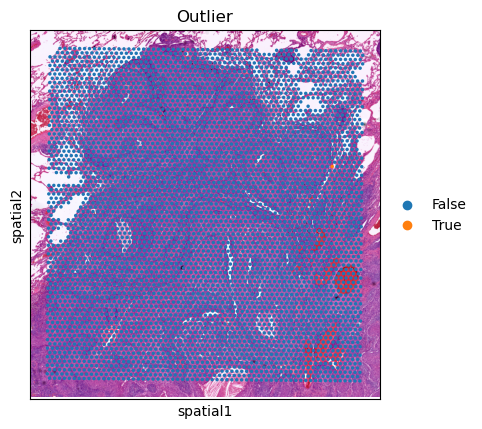

In [20]:
sc.pl.spatial(adata, img_key="hires", color="Cell outlier", title="Outlier", show=False)
plt.gcf().savefig(os.path.join(slide_result_dir, f"outlier_{slide}.png"))

### Apply filters


In [21]:
adata = adata[(~adata.obs["Cell outlier"])].copy()

## Normalisation


In [22]:
# Normalising without keeping raw data
sc.pp.normalize_total(adata, inplace=True, target_sum=1e4)  # Shifted algorithm
sc.pp.log1p(adata)  # log1p transform

In [23]:
# #  Normalising adding a layer
# scales_counts = sc.pp.normalize_total(adata, inplace=False)  # Shifted algorithm
# adata.layers["log1p_norm"] = sc.pp.log1p(
#     scales_counts["X"], copy=True
# )  # log1p transform

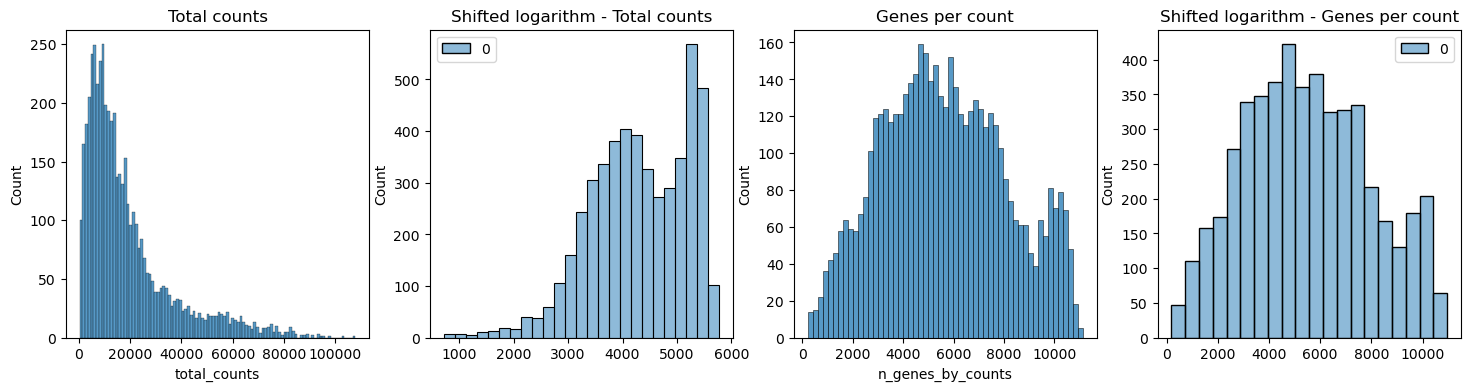

In [24]:
da.plot_count_gene_dist_normal(adata)
plt.gcf().savefig(os.path.join(slide_result_dir, f"post_qc_{slide}.png"))

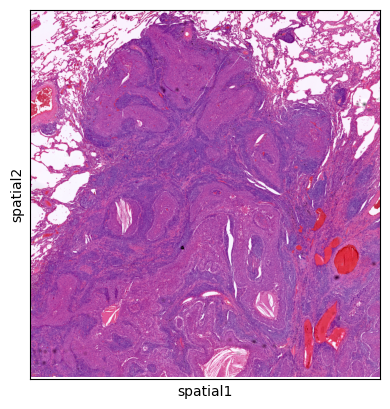

In [25]:
sc.pl.spatial(adata, img_key="hires", show=False)
plt.gcf().savefig(os.path.join(slide_result_dir, f"histo_{slide}.png"))

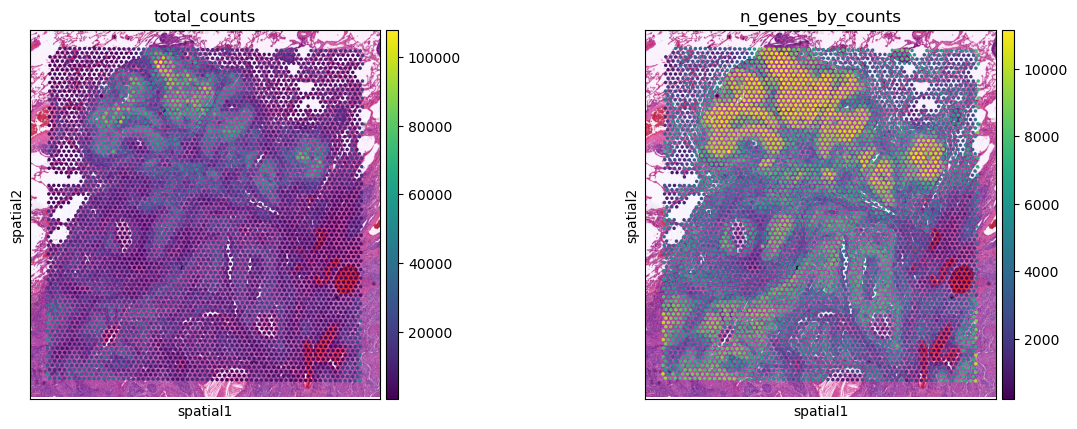

In [26]:
sc.pl.spatial(
    adata, img_key="hires", color=["total_counts", "n_genes_by_counts"], show=False
)
plt.gcf().savefig(os.path.join(slide_result_dir, f"histo_qc_{slide}.png"))

## Dimension reduction


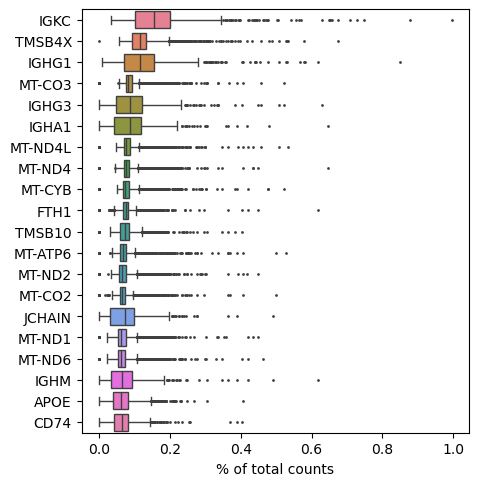

In [27]:
sc.pl.highest_expr_genes(adata, n_top=20, show=False)
plt.gcf().savefig(os.path.join(slide_result_dir, f"high_exp_genes_{slide}.png"))

In [28]:
# Feature selection
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

In [29]:
# Dimension reduction and clustering
sc.pp.pca(adata, n_comps=50, mask_var="highly_variable", svd_solver="arpack")

sc.pp.neighbors(adata)
sc.tl.umap(adata)

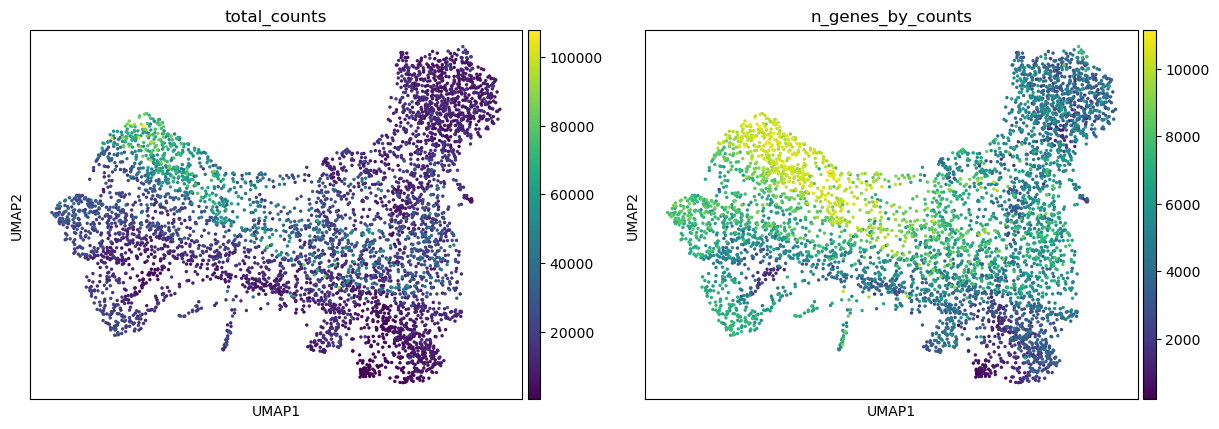

In [30]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts"], show=False)
plt.gcf().savefig(os.path.join(slide_result_dir, f"umap_qc_{slide}.png"))

## Clustering


In [31]:
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)

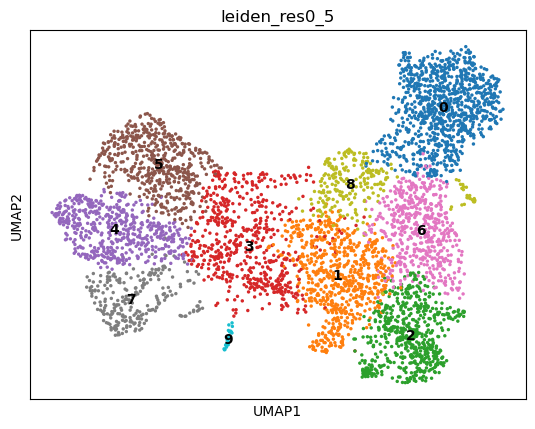

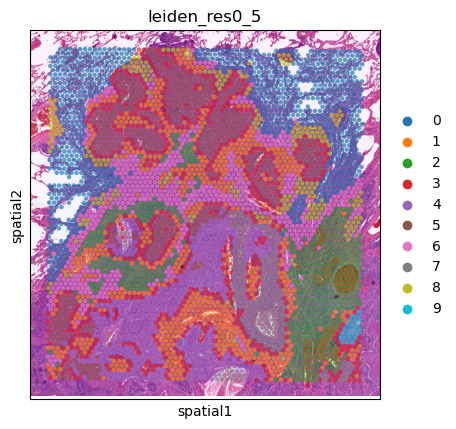

In [32]:
sc.pl.umap(adata, color=["leiden_res0_5"], legend_loc="on data", show=False)
plt.gcf().savefig(os.path.join(slide_result_dir, f"umap_cluster_{slide}.png"))

sc.pl.spatial(
    adata, img_key="hires", color="leiden_res0_5", alpha=0.7, size=1.3, show=False
)
plt.gcf().savefig(os.path.join(slide_result_dir, f"histo_cluster_{slide}.png"))

In [33]:
# sc.tl.rank_genes_groups(adata, "leiden_res0_5", inplace=True)
# sc.pl.rank_genes_groups_heatmap(adata, groupby="leiden_res0_5", show_gene_labels=True, show=False)
# plt.gcf().savefig(os.path.join(slide_result_dir, f"genes_cluster_{slide}.png"))

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json


Annotation was donne using model trained on Human_Lung_Atlas.pkl data


📚 Total models in list: 54
📂 Storing models in /home/agathes/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Human_Lung_Atlas.pkl
🔬 Input data has 4924 cells and 13776 genes
🔗 Matching reference genes in the model
🧬 4017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


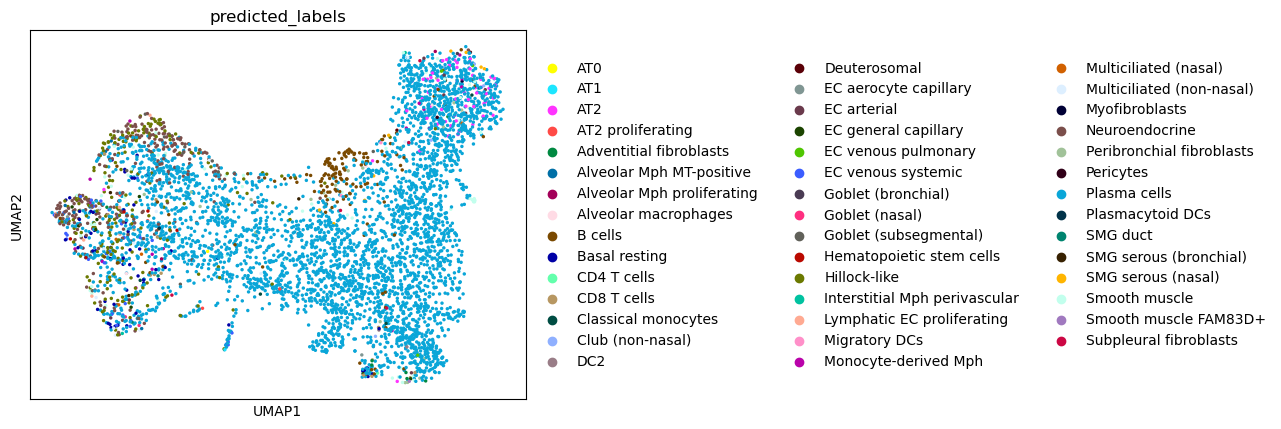

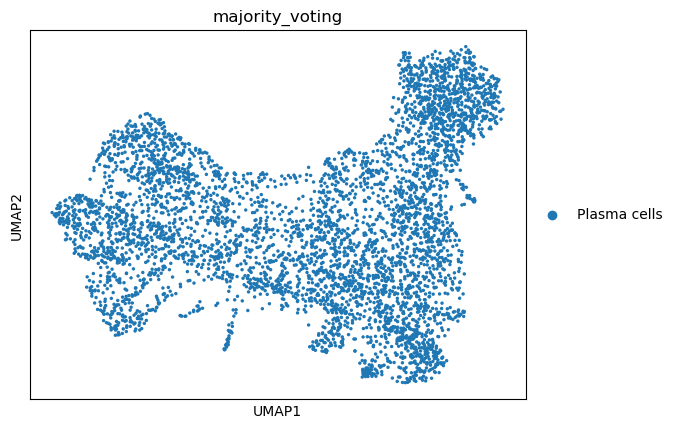

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/agathes/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Immune_All_Low.pkl


Annotation was donne using model trained on Immune_All_Low.pkl data


🔬 Input data has 4924 cells and 13776 genes
🔗 Matching reference genes in the model
🧬 4623 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


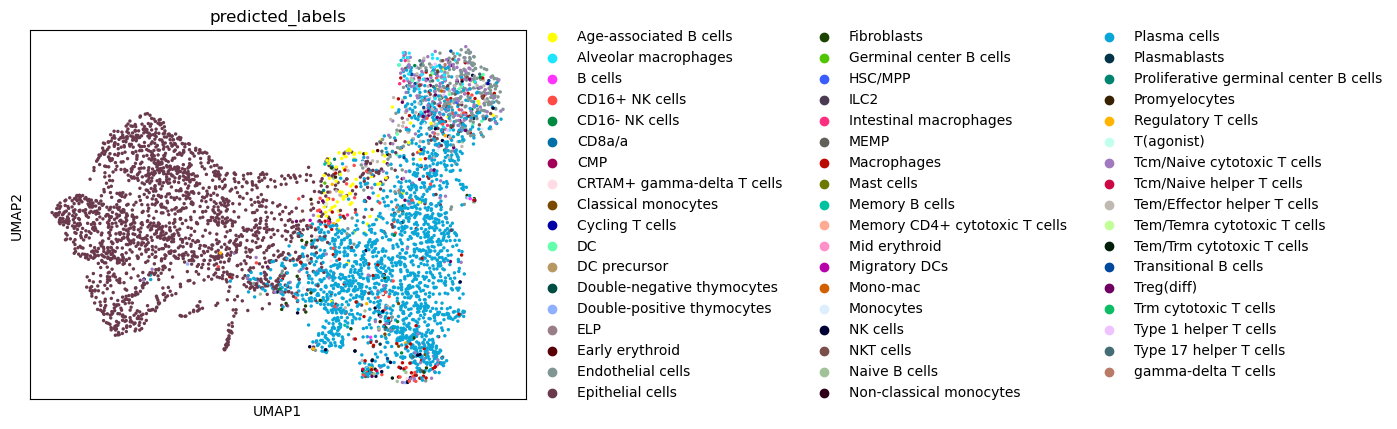

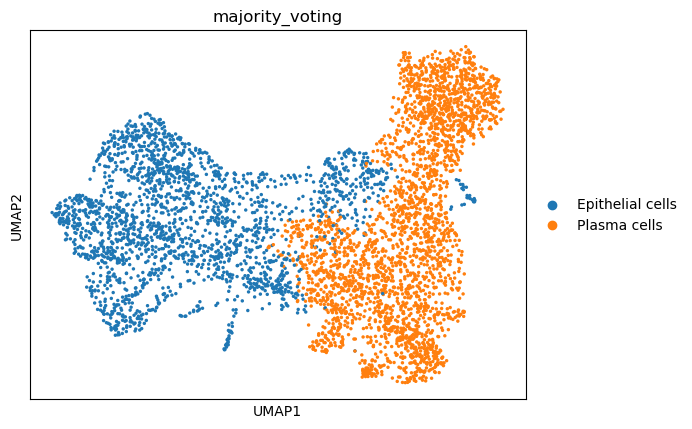

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json


Annotation was donne using model trained on Immune_All_High.pkl data


📚 Total models in list: 54
📂 Storing models in /home/agathes/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Immune_All_High.pkl
🔬 Input data has 4924 cells and 13776 genes
🔗 Matching reference genes in the model
🧬 4623 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


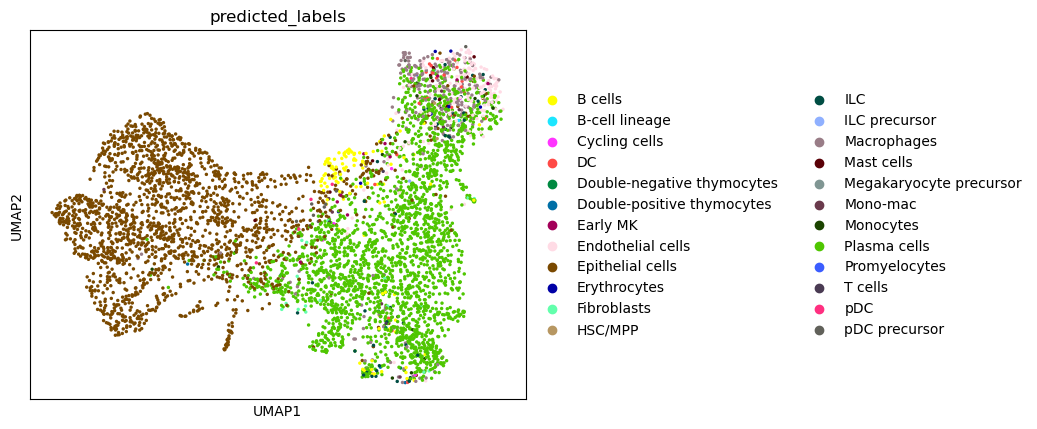

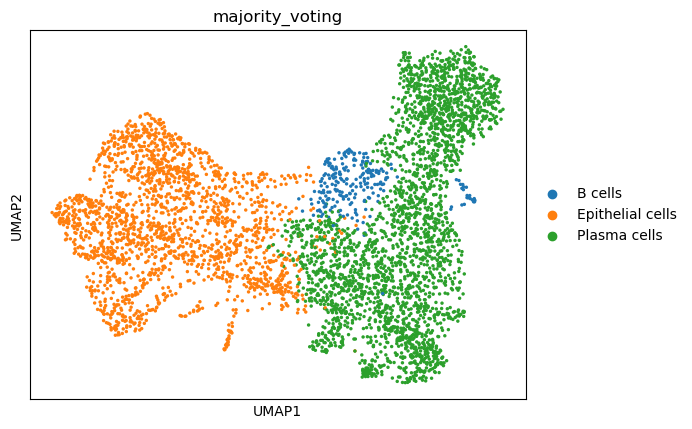

In [34]:
for model_name in ["Human_Lung_Atlas.pkl", "Immune_All_Low.pkl", "Immune_All_High.pkl"]:
    print(f"Annotation was donne using model trained on {model_name} data")
    ct.models.download_models(model=[model_name], force_update=True)
    model = ct.models.Model.load(model=model_name)
    predictions = ct.annotate(
        adata, model=model_name, majority_voting=True, over_clustering="leiden_res0_5"
    )
    adata = predictions.to_adata()

    sc.pl.umap(adata, color=["predicted_labels"])
    sc.pl.umap(adata, color=["majority_voting"])

In [35]:
genes_names = (
    pd.DataFrame({"gene": list(adata.var_names), "ensemble_id": adata.var["gene_ids"]})
    .sort_values(by="gene")
    .reset_index(drop=True)
)

In [39]:
# Define the marker genes dictionary
if "ADH1B" in list(adata.var_names):
    marker_genes = {
        "ADH1B": "ADH1B, for ADH1B+ CAF",
        "GPC3": "GPC3, other marker for ADH1B+ CAF",
        "TCF21": "TCF21, other marker for ADH1B+ CAF",
        "MYH11": "MYH11, for MYH11+ aSMA+ CAF",
        "ACTA2": "ACTA2, other name for aSMA (aSMA+ CAF)",
        "FAP": "FAP, for FAP+ CAF",
        "CD3D": "CD3D, pan T cells",
        "CD8A": "CD8A, cytotoxic T cells",
        "CD38": "CD38, activated T cells",
        "KRAS": "KRAS, for cancer cells",
    }
elif "ADH1C" in list(adata.var_names):
    marker_genes = {
        "ADH1C": "ADH1C, same family ADH1B (ADH1B+ CAF)",
        "GPC3": "GPC3, other marker for ADH1B+ CAF",
        "TCF21": "TCF21, other marker for ADH1B+ CAF",
        "MYH11": "MYH11, for MYH11+ aSMA+ CAF",
        "ACTA2": "ACTA2, other name for aSMA (aSMA+ CAF)",
        "FAP": "FAP, for FAP+ CAF",
        "NRAS": "NRAS, for cancer cells",
    }
else:
    marker_genes = {
        "GPC3": "GPC3, other marker for ADH1B+ CAF",
        "ACTA2": "ACTA2, other name for aSMA (aSMA+ CAF)",
        "FAP": "FAP, for FAP+ CAF",
        "NRAS": "NRAS, for cancer cells",
    }

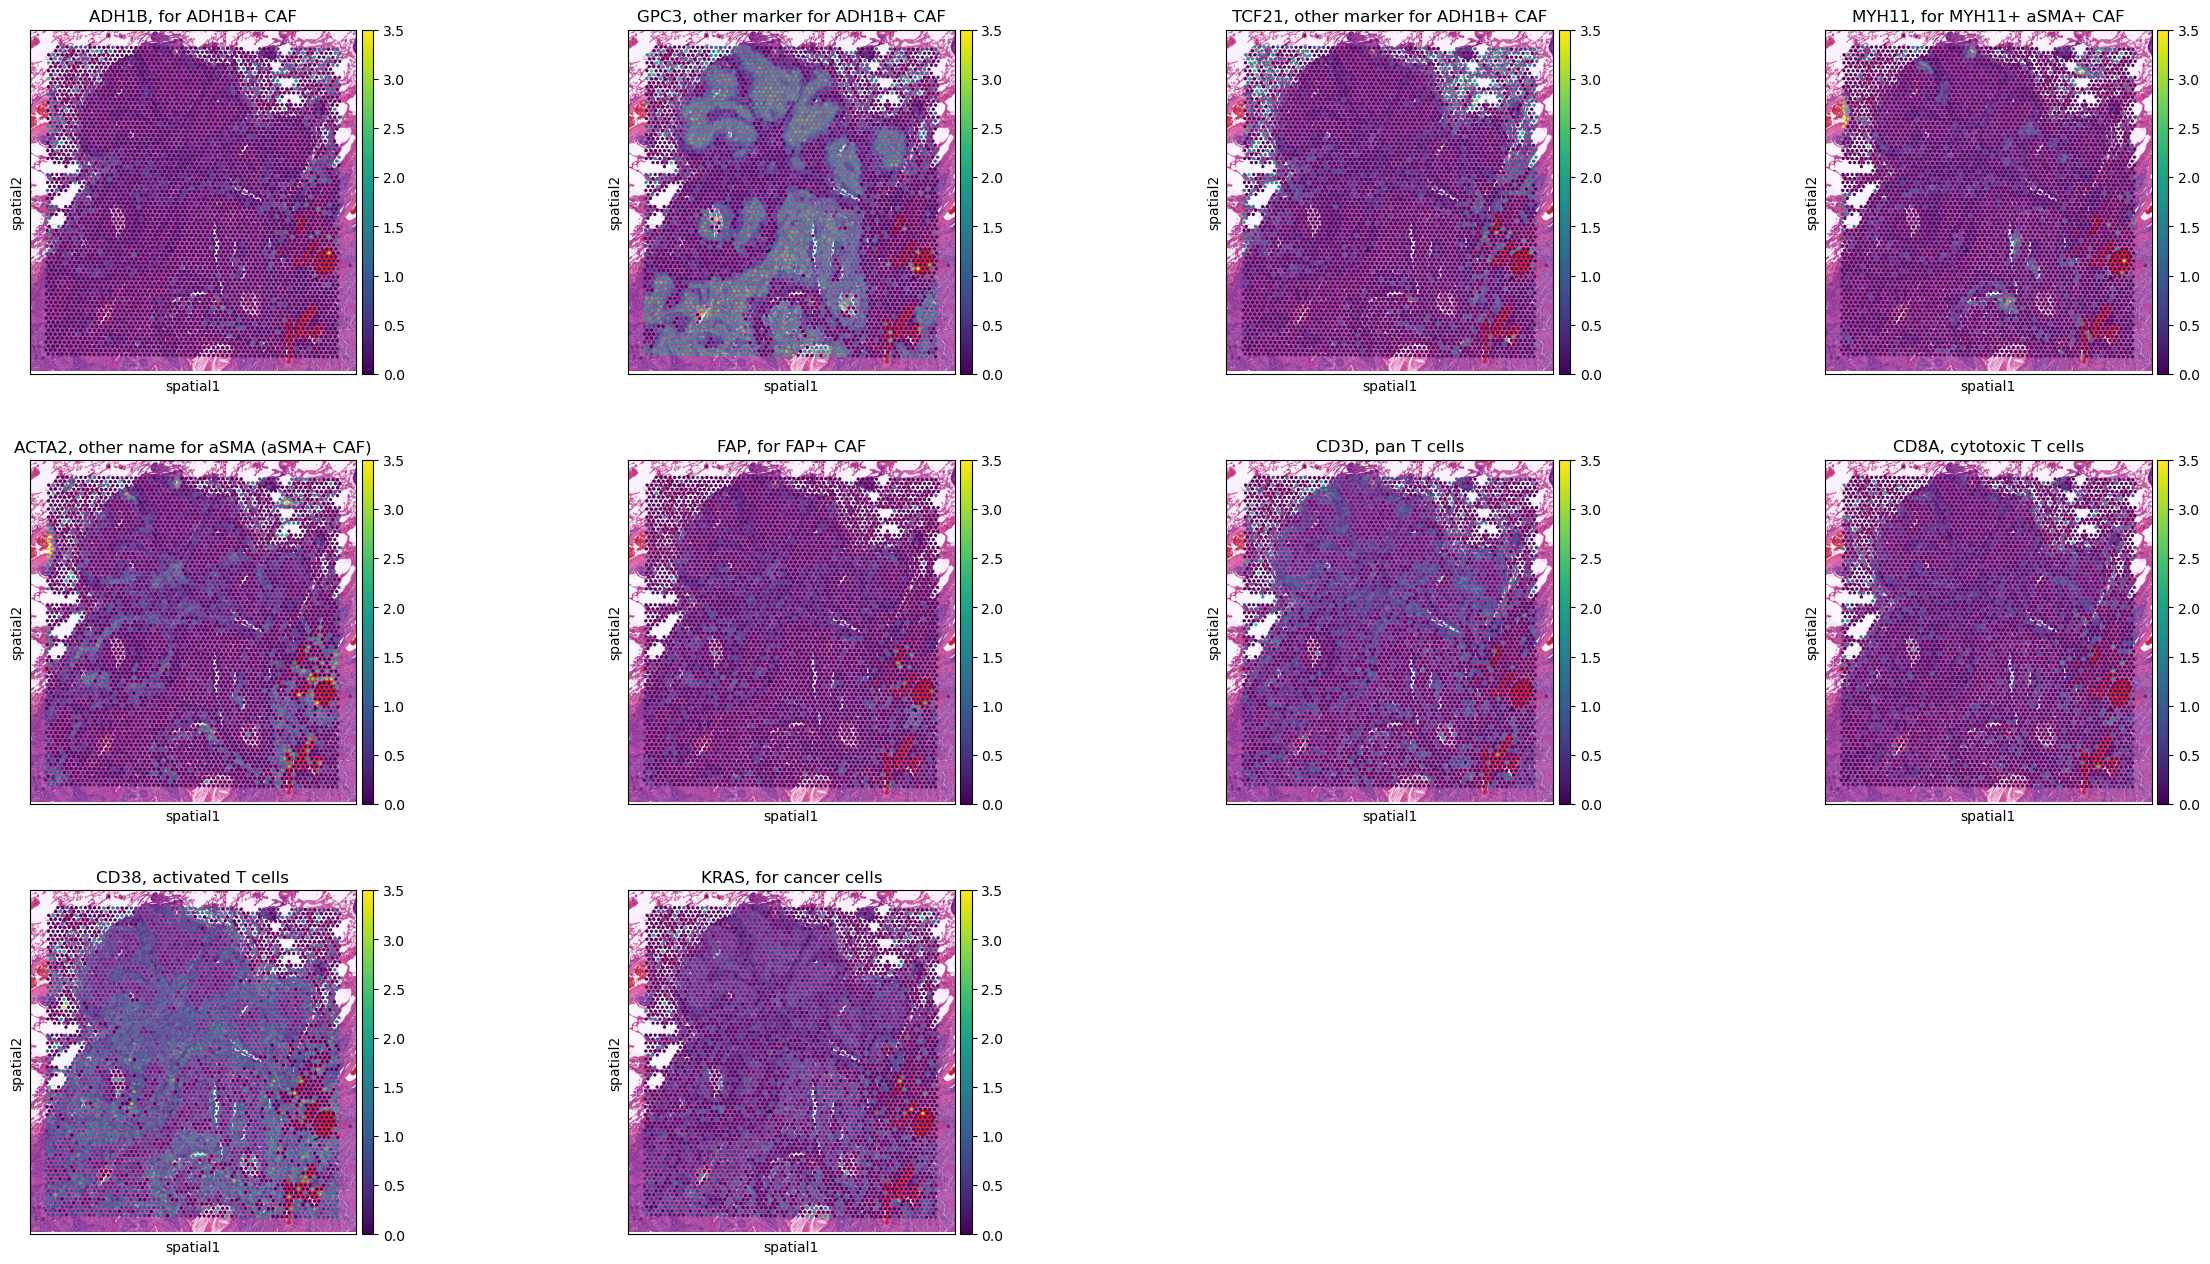

In [40]:
sc.pl.spatial(
    adata,
    img_key="hires",
    vmin=0,
    vmax=3.5,
    color=marker_genes.keys(),
    title=marker_genes.values(),
    #   color_map="Blues",
    show=False,
)
plt.gcf().savefig(os.path.join(slide_result_dir, f"histp_cell_markers_{slide}.png"))

## Create markdow of figures


In [38]:
# from reportlab.lib.pagesizes import letter
# from reportlab.pdfgen import canvas

# for slide in slide_folders:
#     slide_result_dir = os.path.join(result_dir, f"{slide}_results")
#     markdown_dir = os.path.join(result_dir, "Markdowns")
#     os.makedirs(markdown_dir, exist_ok=True)


#     # Create a list of all PNG files in the folder
#     png_files = [f for f in os.listdir(slide_result_dir) if f.endswith('.png')]

#     # Define the output PDF file
#     pdf_output = os.path.join(markdown_dir, f'{slide}_images.pdf')

#     # Create a PDF canvas
#     c = canvas.Canvas(pdf_output, pagesize=letter)

#     for image in png_files:
#         image_path = os.path.join(slide_result_dir, image)

#         # Add the image to the PDF (adjusting the image size and position as needed)
#         c.drawImage(image_path, 50, 400, width=500, height=400)  # Change position/size as needed

#         # Add a new page after each image
#         c.showPage()

#     # Save the PDF
#     c.save()

#     print(f"PDF file '{pdf_output}' has been generated.")